# Procuring OOI Data for John Wilkin
Concise notebook of datastream methods for retrieving and cleaning up OOI data: surface-piercing profiler's spectral irradiance. Set up to run on OOI kernel jupyter-lab (jupyter.oceanobservatories.org).

author: Turner E Johnson

date: 2023-10-14
most recent!!

In [1]:
#package installation cell: from Ian Black OSU
%matplotlib inline

import importlib
import subprocess
import sys
import os
packages = ['seaborn','imageio','xarray','prettytable','tqdm']  

for package in packages:
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, '-m' ,'pip','install',package])

In [2]:
#package import cell
%matplotlib inline

import csv
import io
import numpy as np
import os
import pandas as pd
import re
import sys
import time
import xarray as xr
import seaborn as sns
from tqdm import tqdm

from ooi_data_explorations.common import get_vocabulary, list_deployments,load_kdata, N_CORES, FILL_INT
from ooi_data_explorations.uncabled.process_optaa import optaa_cspp
from ooi_data_explorations.uncabled.process_spkir import spkir_cspp
from ooi_data_explorations.profilers import create_profile_id, bin_profiles

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from tqdm import tqdm
from scipy import stats
#from prettytable import PrettyTable

### Manual, one at a time way:
Each surface-piercing profiler (at 4 sites) has ~30 deployments which each need to be loaded individually. I load these .nc files into xarray Datasets, which maintains metadata. I'm using Chris Wingard's function load_kdata from his ooi_data_explorations package, which tunnels into data directories located on the same server as this JupyterLab. It is much faster than THREDDS/URL loading.

In [29]:
# SPKIR (spectral irradiance) request params
site = 'CE02SHSP'           # OOI Net site designator: Oregon Shelf
node = 'SP001'              # OOI Net node designator
sensor = '06-SPKIRJ000'     # OOI Net sensor designator: Spectral Irradiometer
stream = 'spkir_abj_cspp_instrument_recovered'  # OOI Net stream name
method = 'recovered_cspp'   # OOI Net data delivery method
level = 'profiler'              # local directory name, level below site
instrmt = 'spkir'           # local directory name, instrument below level

deploy = 2 # specify deployment here
vocab = get_vocabulary(site, node, sensor)[0]

# load data from the local kdata directory (on kernel)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))

#turner put rest of tut here

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


In [3]:
# functions for automating.

#spkir_load_deployments: loads all deployments into a dictionary of datasets.
# returns dictionary of datasets and dataframe of summary data.
def spkir_load_deployments(site= 'CE02SHSP',node= 'SP001',sensor= '06-SPKIRJ000'):
    deployments_count = max(list_deployments(site, node, sensor))
    spkir_dict = {}
    for deploy in range(1, deployments_count+1): 
        var_name = f"spkir{deploy}"   
        stream = 'spkir_abj_cspp_instrument_recovered' 
        method = 'recovered_cspp'
        level = 'profiler'
        instrmt = 'spkir'
        vocab = get_vocabulary(site, node, sensor)[0]
        dataset = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy)) #requires ooinet connection
        spkir_dict[var_name] = dataset
    valid_keys = []
    len_1 = []
    len_2 = []
    for name,ds in list(spkir_dict.items()):
        if ds is not None:
            valid_keys.append(name)
            len_1.append(len(ds.time))
            ds = spkir_cspp(ds)
            ds = create_profile_id(ds)
            vocab = get_vocabulary(ds.attrs['subsite'],ds.attrs['node'], ds.attrs['sensor'])[0]
            site_depth = vocab['maxdepth'] -2
            profiles = ds.groupby('profile')
            profiles = [profile[1] for profile in profiles]
            partial_binning = partial(bin_profiles, site_depth=site_depth, bin_size=0.5)

            with ProcessPoolExecutor(max_workers=N_CORES) as executor:
                binned = list(tqdm(executor.map(partial_binning, profiles), total=len(profiles),
                               desc='{}: smoothing and binning each profile into 0.5m depth bins'.format(name), file=sys.stdout))
            binned = [i[0] for i in binned if i is not None]
            binned = xr.concat(binned, 'time')
            ds = binned.sortby(['profile', 'time'])
            ds['depth'] = -ds['depth']
            len_2.append(len(ds.time))
            spkir_dict[name] = ds
        else:
            print("Invalid dataset:",name,"has no data.")

    summary_df = pd.DataFrame({'deployment': valid_keys,
                               'initial_length': len_1,
                               'binned_length': len_2})
    return [spkir_dict, summary_df]

def spkir_contempCal(spkir_dict):
    #:: adds 7 contemp cal variables to each profile in the deployment ds.
    #:: input spkir dictionary 
    #:: returns updated spkir dictionary.
    dw_E_list = ["downwelling_irradiance_412", "downwelling_irradiance_444",
             "downwelling_irradiance_490","downwelling_irradiance_510",
             "downwelling_irradiance_555","downwelling_irradiance_620",
             "downwelling_irradiance_683"]
    calContemp_E_list = ["cal_E_412_C","cal_E_444_C","cal_E_490_C","cal_E_510_C","cal_E_555_C","cal_E_620_C","cal_E_683_C"]
    for name,ds in list(spkir_dict.items()):
        if ds is not None:
            for var in calContemp_E_list:
                #dev consider making this -999
                ds[var] = ds.downwelling_irradiance_412 * 100 #dummy variables to to be repopulated

            for p in range(1, int(max(ds.profile.values)) + 1): #profiles start at 1 and end at true number: needs +1
                profile = ds.where(ds.profile == p, drop=True) #select profile by p_number
                if profile is not None and len(profile.time) != 0: #skip profile if it is empty.
                    for band, cal_var in zip(dw_E_list, calContemp_E_list): #toss out profile if bad band
                        cal_data = profile[band] - np.min(profile[band].values) + np.spacing(1)
                        ds[cal_var].loc[ds.profile == p] = cal_data
                else: print("Bad profile",p,"in",name)
            spkir_dict[name] = ds
            print("{} now has {} variables!".format(name,len(ds)))
        else:
            print("Invalid dataset:",name,"has no data.")
    return spkir_dict

def plot_depth_profiles(dictionary, deploy, pnum, band_list,title_descriptor):
    colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
    pal = sns.color_palette(colors)
    
    grouped_deploy = dictionary[deploy].groupby('profile')
    profile = grouped_deploy[pnum]
    fig,ax = plt.subplots(1,2,figsize=(7,5),dpi=200)
    for i,band in enumerate(dw_E_list):
        lbl = re.findall(r'\d+', band)
        ax[0].plot(profile[band], profile.depth,color = pal[i],alpha=0.6,label = lbl,linewidth = -.8)
        ax[1].plot(np.log(profile[band]),profile.depth,color=pal[i],alpha=0.6,label=lbl)

    ax[0].set_ylabel("depth (m)")
    ax[0].set_xlabel("spectral irradiance E (uW cm-2 nm-1)")
    ax[1].set_xlabel("Log(E) (uW cm-2 nm-1)")
    ax[0].set_title("Spectral Irradiance")
    ax[1].set_title("Log of Spectral Irradiance")

    ax[0].legend(fontsize=7)
    ax[1].legend(fontsize=7)
    fig.suptitle("{} depth profile {} in deployment {}".format(title_descriptor,pnum,deploy), y=1)
    plt.show()

In [4]:
#testing plot_depth_profile function.
# 3/26 something funky with this. ugly first of all. new font?
calNight_E_list = ["cal_E_412_N","cal_E_444_N","cal_E_490_N","cal_E_510_N","cal_E_555_N","cal_E_620_N","cal_E_683_N"]
dw_E_list = ["downwelling_irradiance_412", "downwelling_irradiance_444",
             "downwelling_irradiance_490","downwelling_irradiance_510",
             "downwelling_irradiance_555","downwelling_irradiance_620",
             "downwelling_irradiance_683"]

plot_depth_profiles(spkir_dict34, 'spkir7', 2.0, calNight_E_list,'nightCal')

NameError: name 'spkir_dict34' is not defined

Calling functions one at a time to act on a dictionary object full of all deployments for the site. This first function,spkir_load_deployments, takes the longest to run.

In [4]:
spkir_dict,summary_df = spkir_load_deployments(site= 'CE02SHSP',node= 'SP001',sensor= '06-SPKIRJ000')

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:00<00:00, 15.09it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:00<00:00, 17.93it/s]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:00<00:00, 18.85it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Loading and Processing Data Files: 0it [00:00, ?it/s]
/home/jovyan/code/ooi-data-explorations/python/ooi_data_explorations/common.py:856: UserWarning: No data files were loaded from the JupyterHub kdata directory.
  warnings.warn(message)


Loading and Processing Data Files: 0it [00:00, ?it/s]


Loading and Processing Data Files: 0it [00:00, ?it/s]


spkir1: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 47/47 [00:03<00:00, 15.41it/s]
spkir2: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 102/102 [00:05<00:00, 17.08it/s]
spkir3: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 101/101 [00:04<00:00, 21.59it/s]
spkir4: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 78/78 [00:04<00:00, 18.50it/s]
spkir5: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 38/38 [00:02<00:00, 16.26it/s]
spkir6: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 15/15 [00:00<00:00, 15.63it/s]
spkir7: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 103/103 [00:06<00:00, 16.72it/s]
spkir8: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 43/43 [00:02<00:00, 15.62it/s]
spkir9: smoothing and binning each profile into 0.5m depth bins: 100%|██████████| 41/41 [0

The next function, spkir_contempCal, creates 7 new variables, one for each λ of spectral irradiance, calibrated to zero their minimum value + translate everything else up/down. This function has a pretty short runtime.

In [5]:
spkir_dict2 = spkir_contempCal(spkir_dict)

spkir1 now has 33 variables!
spkir2 now has 33 variables!
spkir3 now has 33 variables!
spkir4 now has 33 variables!
spkir5 now has 33 variables!
spkir6 now has 33 variables!
spkir7 now has 33 variables!
spkir8 now has 33 variables!
spkir9 now has 33 variables!
spkir10 now has 33 variables!
spkir11 now has 33 variables!
spkir12 now has 33 variables!
spkir13 now has 33 variables!
spkir14 now has 33 variables!
spkir15 now has 33 variables!
spkir16 now has 33 variables!
spkir17 now has 33 variables!
spkir18 now has 33 variables!
spkir19 now has 33 variables!
spkir20 now has 33 variables!
spkir21 now has 33 variables!
Bad profile 11 in spkir22
Bad profile 31 in spkir22
spkir22 now has 33 variables!
spkir23 now has 33 variables!
spkir24 now has 33 variables!
spkir25 now has 33 variables!
spkir26 now has 33 variables!
spkir27 now has 33 variables!
spkir28 now has 33 variables!
spkir29 now has 33 variables!
spkir30 now has 33 variables!
spkir31 now has 33 variables!
spkir32 now has 33 variable

In [6]:
def spkir_nightCal(spkir_dict,summary_df):
    #:: adds 7 night cal variables to each profile in the deployment ds.
    #:: input spkir dictionary, summary df
    #:: returns updated spkir noons dictionary and updated summary df

    spkirNoons_dict = {}
    spkirNoons_dict_grouped = {}
    len3 = [] #empty list for recording new lengths for summary_df
    
    displayLog = False
    handPickNoonProfiles = False
    showAllPlots = False
    
    dw_E_list = ["downwelling_irradiance_412", "downwelling_irradiance_444",
             "downwelling_irradiance_490","downwelling_irradiance_510",
             "downwelling_irradiance_555","downwelling_irradiance_620",
             "downwelling_irradiance_683"]
    dw_E_labels = ["412nm raw", "444nm raw","490nm raw","510nm raw","555nm raw","620nm raw","683nm raw"]
    calNight_E_list = ["cal_E_412_N","cal_E_444_N","cal_E_490_N","cal_E_510_N","cal_E_555_N","cal_E_620_N","cal_E_683_N"]
    calNight_E_labels = ["412nm cal ","444nm cal","490nm cal","510nm cal","555nm cal","620nm cal","683nm cal"]
    
    #slope of log fit
    avg_Kd_list = ["Kd_avg_412","Kd_avg_444","Kd_avg_490","Kd_avg_510","Kd_avg_555","Kd_avg_620","Kd_avg_683"]
    
    #intercept of log fit
    extrap_srfc_dw_E_list = ["srfc_dwE_412","srfc_dwE_444","srfc_dwE_490","srfc_dwE_510","srfc_dwE_555","srfc_dwE_620","srfc_dwE_683"]
    
    #first derivative of irradiance w.r.t. depth
    dEdz_list = ['dEdz_412','dEdz_444','dEdz_490','dEdz_510','dEdz_555','dEdz_620','dEdz_683']
    
    colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
    pal = sns.color_palette(colors)
    noon_start_hour,noon_end_hour = 16, 22 #UTC
    
    for name, ds in list(spkir_dict.items()):
        
        if ds is not None:   
            
            for i,band in enumerate(avg_Kd_list): #initialising calNight_E_list var labels
                ds[calNight_E_list[i]] = ds.downwelling_irradiance_683 * 100000
                ds[band] = ds.downwelling_irradiance_683 * -100000
                ds[extrap_srfc_dw_E_list[i]] = ds.downwelling_irradiance_683 * -500000
                ds[dEdz_list[i]] = ds.downwelling_irradiance_683 * 500000
                
            #-- determining noon-time profiles within deployment ds ---------------------------------------------
            ds_noons = ds.where((ds.time.dt.hour >= noon_start_hour) & (ds.time.dt.hour <= noon_end_hour),drop=True)
            noon_profile_nums = np.unique(ds_noons.profile)
            
            if handPickNoonProfiles:
                profile_colors = plt.cm.tab20b(np.linspace(0, 1, len(noon_profile_nums)))
                plt.figure(figsize=(10, 6),dpi=180)  
                for profile, color in zip(noon_profile_nums, profile_colors):
                    mask_hpk = ds_noons['profile'] == profile
                    plt.scatter(ds_noons['time'][mask_hpk],ds_noons['depth'][mask_hpk],s=3,c=[color],label=f'profile {profile}')
                legend_marker_size = 60
                handler_map = {tuple: HandlerTuple(ndivide=None)}
                scatter_legend = plt.legend(handler_map=handler_map,loc='center left',bbox_to_anchor=(1, 0.5))
                for handle in scatter_legend.legend_handles:
                    handle.set_sizes([legend_marker_size])
                plt.title("{} noon profiles in deployment {}".format(len(np.unique(ds_noons.profile)),name))
                plt.show()
                user_input = input("Profiles to delete for deployment {} (space-separated integers): ".format(name))
                profiles_to_drop = [int(x) for x in user_input.split()]
                print("Dropping profile(s):",profiles_to_drop,"if in noons list.")
                for bad_profile in profiles_to_drop:
                    ds_noons = ds_noons.where(ds_noons.profile != bad_profile, drop=True)
            
            #dev: swapping dims could happen here
            '''
            print(ds.coords)
            ds = ds.assign_coords(profile=ds['profile'])
            ds = ds.swap_dims({'time': 'profile'})
            print(ds.coords)
            profiles = ds.groupby('profile')

            print(ds_noons.coords)
            ds_noons = ds_noons.assign_coords(profile=ds_noons['profile'])
            ds_noons = ds_noons.swap_dims({'time': 'profile'})
            print(ds_noons.coords)
            '''

        
            #-- determining nearby night-time profiles, within /pm 10 casts for every nooncast ---------------------------
            night_start_hour,night_end_hour = 4,11 #UTC
            len_before_drops = len(ds_noons.time)
            
            #initialise empty ds_noons_cal.
            ds_noons_cal = None
            for noon_pnum in tqdm(noon_profile_nums,desc = "Calculating nightCals for {}".format(name)):
                noon_cast = ds.where(ds.profile == noon_pnum, drop=True) #should just be profile of ds_noons?
                nearby_night_casts = ds.where(
                    (ds.profile >= noon_pnum - 10) & (ds.profile <= noon_pnum + 10) &
                    (ds.time.dt.hour >= night_start_hour) & (ds.time.dt.hour <= night_end_hour), drop=True)
                
                if len(np.unique(nearby_night_casts.profile)) == 0:
                    if displayLog:
                        print("Invalid profile",noon_pnum,". No night casts within ± 10 profiles; without cal values the selected noon profile is being deleted.")
                    ds_noons = ds_noons.where(ds_noons.profile != noon_pnum, drop=True)
                else:
                    if displayLog:
                        print("for profile",noon_pnum,"there are",np.unique(nearby_night_casts.profile),"as near night casts")
                    
                    #---- from list of nearby_night_casts, calculating closest cast to selected noon cast -----------------------
                    smallest_time_delta = float("inf")
                    closest_profile = None

                    for profile_num in np.unique(nearby_night_casts.profile):
                        current_profile_data = ds.where(ds.profile == profile_num, drop=True)
                        current_profile_datetime = current_profile_data.time[0].values
                        noon_cast_datetime = noon_cast.time[0].values
                        time_diff_seconds = abs(np.timedelta64(current_profile_datetime - noon_cast_datetime).astype('timedelta64[s]').astype(float))
                        if time_diff_seconds < smallest_time_delta:
                            smallest_time_delta = time_diff_seconds
                            closest_profile = profile_num
                    #print("| for noon cast",noon_profile,"nearest night cast is", closest_profile)
                    
                    #----- using cal data from closest_profile (night), make math adjustments to noon_profile in question. -----------
                    #taking mins of nearest night profile
                    night_cast = ds.where(ds.profile == closest_profile,drop=True)
                    night_mins=[]

                    for band in dw_E_list:
                        min_value = np.min(night_cast[band].values)
                        night_mins.append(min_value)
                        
                    #now using night_mins from closest_profile, we are calibrating the noon_cast.
                    
                    #initializing depth mask for 10m fit.
                    z10m_array = np.arange(-10, -1, 0.5)
                    noon_cast10 = noon_cast.where(noon_cast['depth'].isin(z10m_array),drop=True)
                                        
                    # Update ds_noons with calibrated data from profile
                    for i, band in enumerate(dw_E_list):
                        cal_data = noon_cast[band] - night_mins[i] + np.spacing(1)
                        noon_cast[calNight_E_list[i]] = cal_data
                        
                        
                        #### dev turner 4/22 ################
                        # first subselect E values at integer depths.
                        depth_values_rounded = np.round(noon_cast['depth']).astype(int)
                        indices = np.where(np.isin(noon_cast['depth'].values, depth_values_rounded))
                        subselected_values = cal_data.isel(depth=indices)

                        
                        # then subselect E values at 0.5 (non-integer) depths.
                        
                        ## end dev turner 4/22 ###############
                        
                        # Calculate the first derivative of downwelling irradiance with respect to depth
                        dEdz = (np.diff(cal_data) / np.diff(noon_cast['depth']) )
                        #adding one element to make it the same length as the original 'cal_E_412_N'
                        dEdz = np.concatenate(([np.nan], dEdz)) / cal_data
                        
                        noon_cast[dEdz_list[i]].values = dEdz
                        
                        #---- log fit to calculate average Kd and surface z=0 downwelling irr ----------
                        if len(z10m_array)-len(noon_cast10.depth.values) > 0:
                            #break loop. do not add noon_cast to ds_noons_cal.
                            cal_data10 = np.full(len(noon_cast10),np.nan)
                            slope10, intercept10, r_value10, p_value10, std_err10 = np.nan,np.nan,np.nan,np.nan,np.nan
                        else:
                            cal_data10 = noon_cast10[band] - night_mins[i] + np.spacing(1)
                            slope10, intercept10, r_value10, p_value10, std_err10 = stats.linregress(z10m_array, np.log(cal_data10))
                        avg_Kd = slope10 # this is still in log space!
                        srfc_dwE = np.exp(intercept10) # this is no longer in log space!
                        size = len(noon_cast[avg_Kd_list[i]])
                        noon_cast[avg_Kd_list[i]].values = np.full(size,avg_Kd)
                        noon_cast[extrap_srfc_dw_E_list[i]].values = np.full(size,srfc_dwE)
                        
                    
                    if ds_noons_cal is None:
                        ds_noons_cal = noon_cast
                    else:
                        ds_noons_cal = xr.concat([ds_noons_cal, noon_cast], dim='time')

                    #group the ds by profile to make it easy to pull profiles out!
                    #noon_profiles = ds_noons.groupby('profile') this is the funky line. only thing i can think is to do this after all profiles.
                        
                    if showAllPlots:
                        profile = ds_noons.where(ds_noons.profile == noon_pnum)
                        fig,ax = plt.subplots(1,2,figsize=(9, 5),dpi=180)

                        for i,lam in enumerate(calNight_E_list):
                            ax[0].plot(noon_cast[lam], noon_cast['depth'], color = pal[i], label = calNight_E_labels[i])
                            ax[0].plot(noon_cast[dw_E_list[i]], noon_cast['depth'], color = pal[i], alpha = 0.2, label= dw_E_labels[i])
                        ax[0].set_title("Night-Calibrated spkir for profile {}".format(np.unique(noon_cast.profile)),fontsize=12)
                        ax[0].set_xlabel("spectral irradiance (Wm^-2nm^-1)")
                        ax[0].set_ylabel('depth')
                        ax[0].legend(fontsize=6)

                        for i,lam in enumerate(calNight_E_list):
                            ax[1].plot(profile[lam], profile['depth'], color = pal[i], label = calNight_E_labels[i])
                            ax[1].plot(profile[dw_E_list[i]], profile['depth'], color = pal[i], alpha = 0.2, label= dw_E_labels[i])
                        ax[1].set_title("near-zero -0.05 < E < 0.5: profile {}".format(np.unique(profile.profile)),fontsize=12)
                        ax[1].set_xlabel("spectral irradiance (Wm^-2nm^-1)")
                        ax[1].set_ylabel('depth')
                        ax[1].axvline(x=0, color='k', linestyle='--')
                        ax[1].legend(fontsize=6)
                        ax[1].set_xlim(-.05,.5)
                        plt.show()
   
            #length statistics for summary_df.
            len_after_drops = len(ds_noons_cal.time)
            len3.append(len_after_drops)
            
            #------ swapping "time" dimension for profile, depth. -----------
            ds_noons_cal = ds_noons_cal.assign_coords(profile=ds_noons_cal['profile'])
            ds_noons_cal = ds_noons_cal.assign_coords(depth=ds_noons_cal['depth'])
            ds_noons_cal = ds_noons_cal.swap_dims({'time': 'profile'})
            
            #------ adding the entire noons dataset to a new dictionary. ---
            spkirNoons_dict[name] = ds_noons_cal
            spkirNoons_dict_grouped[name] = ds_noons_cal.groupby('profile')
        else:
            if displayLog:
                print("Invalid dataset:",name,"has no data.")
    len3_col = pd.Series(len3, name='nightCal_noons_length')
    summary_df = pd.concat([summary_df, len3_col], axis=1)
        
    return spkirNoons_dict,spkirNoons_dict_grouped,summary_df

In [7]:
spkir_dict_Noons,spkir_dict_Noons_grouped,summary_df_Noons = spkir_nightCal(spkir_dict2,summary_df)

Calculating nightCals for spkir1:   0%|          | 0/20 [00:00<?, ?it/s]


ValueError: Dimensions {'depth'} do not exist. Expected one or more of Frozen({'time': 135})

In [ ]:
# 2 data products: either groupby 
spkir = spkir_dict_Noons['spkir5']
spkir = spkir.groupby('profile')

In [ ]:
spkir_dict_Noons_grouped['spkir5'][1]

In [ ]:
for i in range(1, len(spkir)+1):
    try:
        if spkir[i]:
            profile = spkir[i]
            print(profile.depth.values[-15:-1])
    except KeyError as e:
        print(f"Skipping index {i} due to KeyError: {e}")
        continue

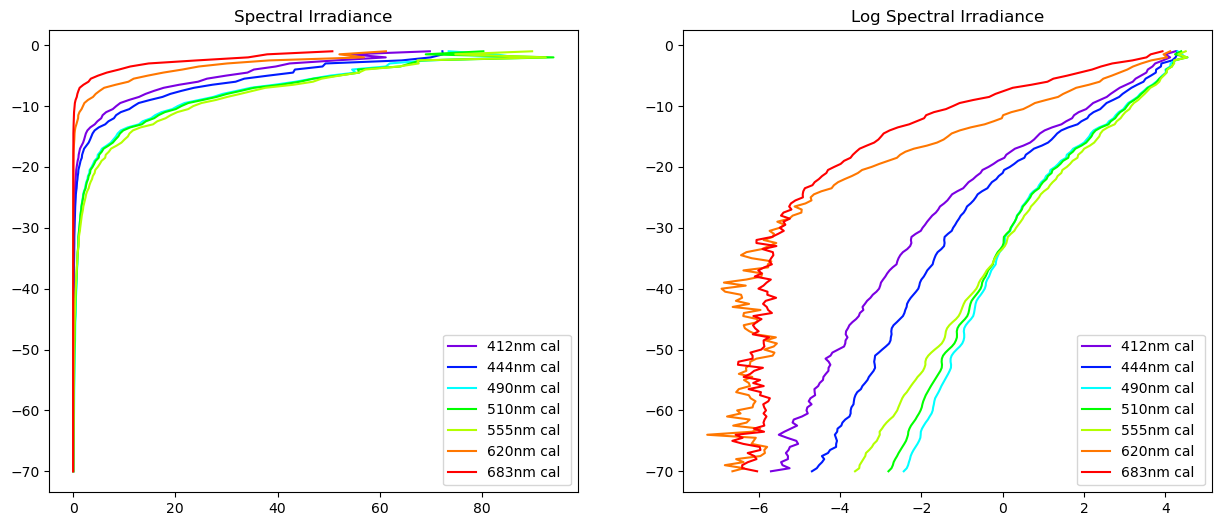

In [13]:
#make this plotting cell into a plotting + fits function.

colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
pal = sns.color_palette(colors)
calNight_E_list = ["cal_E_412_N","cal_E_444_N","cal_E_490_N","cal_E_510_N","cal_E_555_N","cal_E_620_N","cal_E_683_N"]
calNight_E_labels = ["412nm cal ","444nm cal","490nm cal","510nm cal","555nm cal","620nm cal","683nm cal"]
avg_Kd_list = ["Kd_avg_412","Kd_avg_444","Kd_avg_490","Kd_avg_510","Kd_avg_555","Kd_avg_620","Kd_avg_683"]
extrap_srfc_dw_E_list = ["srfc_dwE_412","srfc_dwE_444","srfc_dwE_490","srfc_dwE_510","srfc_dwE_555","srfc_dwE_620","srfc_dwE_683"]
dEdz_list = ['dEdz_412','dEdz_444','dEdz_490','dEdz_510','dEdz_555','dEdz_620','dEdz_683']
z10m_array = np.arange(-10, -1, 0.5)
fig,ax = plt.subplots(1,2,figsize=(15,6))
for i,band in enumerate(calNight_E_list):
    ax[0].plot(profile[band],profile.depth, label=calNight_E_labels[i],color=pal[i])
    ax[1].plot(np.log(profile[band]),profile.depth,label=calNight_E_labels[i],color=pal[i])
    Kd = profile[avg_Kd_list[i]].values[0]
    E0 = profile[extrap_srfc_dw_E_list[i]].values[0]
    log_fit = z10m_array*Kd + E0
    #ax[1].plot(log_fit,z10m_array,color = pal[i],linestyle='--')
ax[0].set_title("Spectral Irradiance")
ax[1].set_title("Log Spectral Irradiance")
ax[1].legend()
ax[0].legend()
plt.show()

In [14]:
profile = spkir[1]
profile

<xarray.Dataset>
Dimensions:                            (profile: 88)
Coordinates:
    depth                              (profile) float64 -44.5 -44.0 ... -1.0
  * profile                            (profile) float64 1.0 1.0 1.0 ... 1.0 1.0
    time                               (profile) datetime64[ns] 2017-02-13T19...
Data variables: (12/59)
    lat                                (profile) float64 44.64 44.64 ... 44.64
    internal_temperature               (profile) float64 38.94 38.83 ... 38.94
    lon                                (profile) float64 -124.3 ... -124.3
    input_voltage                      (profile) float64 8.464 8.272 ... 8.434
    seawater_pressure                  (profile) float32 44.91 44.38 ... 1.012
    deployment                         (profile) float64 5.0 5.0 5.0 ... 5.0 5.0
    ...                                 ...
    srfc_dwE_620                       (profile) float64 71.06 71.06 ... 71.06
    dEdz_620                           (profile) float64 nan -0.397 ... 0.5223
    cal_E_683_N                        (profile) float64 0.001158 ... 40.29
    Kd_avg_683                         (profile) float64 0.6129 ... 0.6129
    srfc_dwE_683                       (profile) float64 69.53 69.53 ... 69.53
    dEdz_683                           (profile) float64 nan -0.03405 ... 0.4896
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             spkir_abj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.299071
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

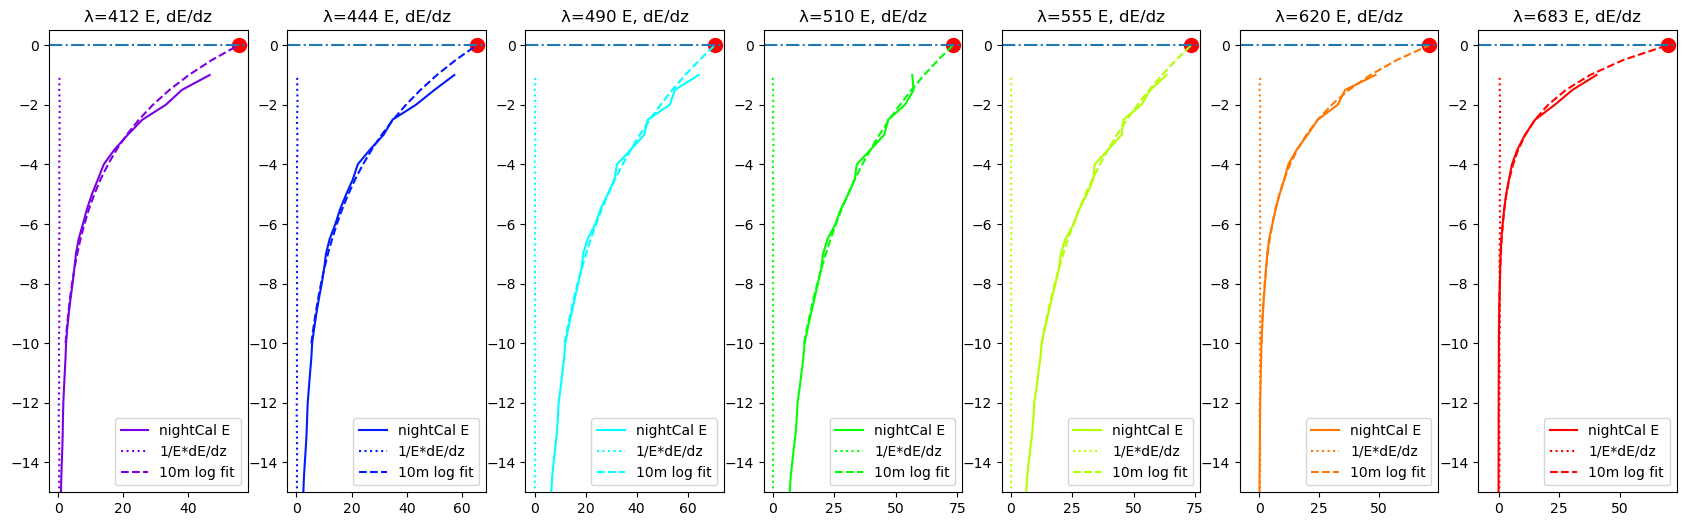

In [15]:
# make this plotting cell into a plotting + fits function. #2

colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
pal = sns.color_palette(colors)
calNight_E_list = ["cal_E_412_N","cal_E_444_N","cal_E_490_N","cal_E_510_N","cal_E_555_N","cal_E_620_N","cal_E_683_N"]
calNight_E_labels = ["412nm cal ","444nm cal","490nm cal","510nm cal","555nm cal","620nm cal","683nm cal"]
avg_Kd_list = ["Kd_avg_412","Kd_avg_444","Kd_avg_490","Kd_avg_510","Kd_avg_555","Kd_avg_620","Kd_avg_683"]
extrap_srfc_dw_E_list = ["srfc_dwE_412","srfc_dwE_444","srfc_dwE_490","srfc_dwE_510","srfc_dwE_555","srfc_dwE_620","srfc_dwE_683"]
dEdz_list = ['dEdz_412','dEdz_444','dEdz_490','dEdz_510','dEdz_555','dEdz_620','dEdz_683']
z10m_array = np.arange(-10, 0.5, 0.5)

fig,ax = plt.subplots(1,7,figsize=(21,6))

for i in range(7):
    ax[i].plot(profile[calNight_E_list[i]],profile.depth, label="nightCal E",color=pal[i])
    ax[i].plot(profile[dEdz_list[i]],profile.depth,label='1/E*dE/dz',color=pal[i],linestyle=":")
    Kd = profile[avg_Kd_list[i]].values[0]
    E0 = profile[extrap_srfc_dw_E_list[i]].values[0]
    ax[i].plot(E0, 0, marker='o', markersize=10, color='red')
    log_fit = E0*np.exp((z10m_array)*Kd)
    ax[i].plot(log_fit,z10m_array,color = pal[i],linestyle='--',label='10m log fit')
    ax[i].legend()
    ax[i].set_ylim(-15,0.5) #optional
    ax[i].axhline(0,linestyle="-.")

ax[0].set_title("λ=412 E, dE/dz")
ax[1].set_title("λ=444 E, dE/dz")
ax[2].set_title("λ=490 E, dE/dz")
ax[3].set_title("λ=510 E, dE/dz")
ax[4].set_title("λ=555 E, dE/dz")
ax[5].set_title("λ=620 E, dE/dz")
ax[6].set_title("λ=683 E, dE/dz")

plt.show()

[0.43562246 0.26226148]
[-2.  -1.5]
[0.39192107 0.26957947]
[-2.  -1.5]
[0.32818406 0.07339068]
[-2.  -1.5]
[0.25430561 0.12283077]
[-2.  -1.5]
[0.27551348 0.12760253]
[-2.  -1.5]
[0.50631606 0.17219147]
[-2.  -1.5]
[0.69968247 0.47925073]
[-2.  -1.5]


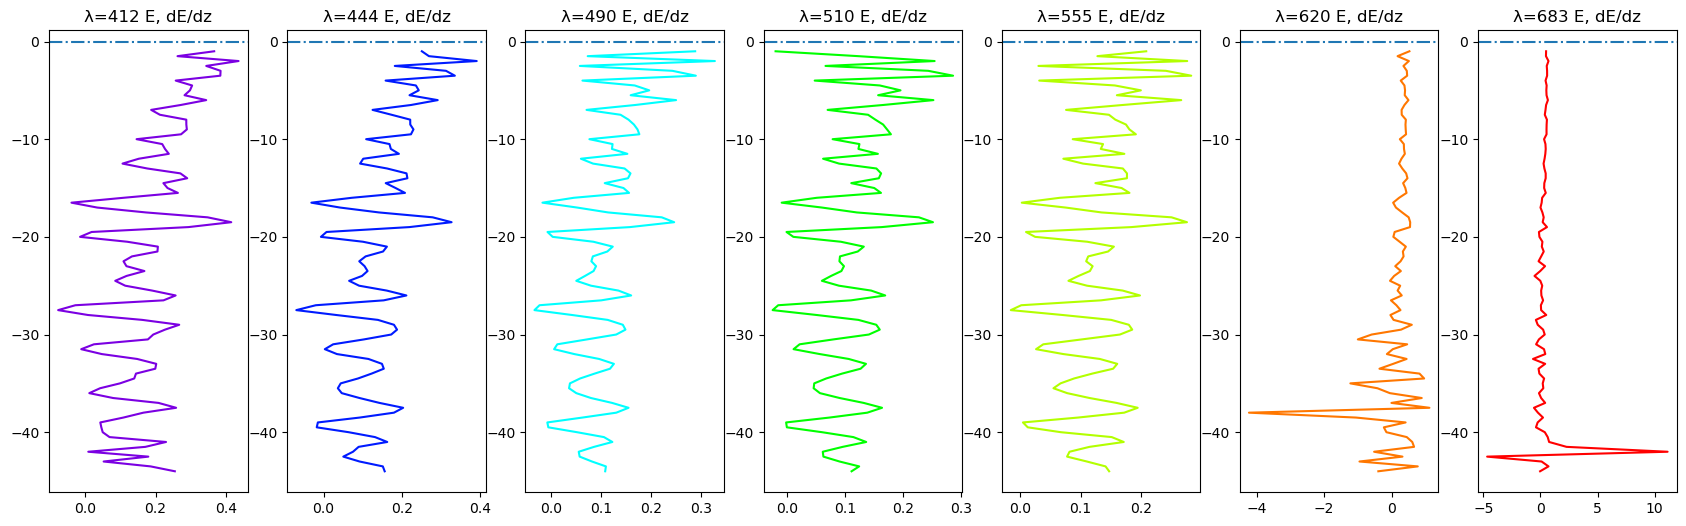

In [16]:
colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
pal = sns.color_palette(colors)
calNight_E_list = ["cal_E_412_N","cal_E_444_N","cal_E_490_N","cal_E_510_N","cal_E_555_N","cal_E_620_N","cal_E_683_N"]
calNight_E_labels = ["412nm cal ","444nm cal","490nm cal","510nm cal","555nm cal","620nm cal","683nm cal"]
avg_Kd_list = ["Kd_avg_412","Kd_avg_444","Kd_avg_490","Kd_avg_510","Kd_avg_555","Kd_avg_620","Kd_avg_683"]
extrap_srfc_dw_E_list = ["srfc_dwE_412","srfc_dwE_444","srfc_dwE_490","srfc_dwE_510","srfc_dwE_555","srfc_dwE_620","srfc_dwE_683"]
dEdz_list = ['dEdz_412','dEdz_444','dEdz_490','dEdz_510','dEdz_555','dEdz_620','dEdz_683']
z10m_array = np.arange(-10, 0.5, 0.5)

fig,ax = plt.subplots(1,7,figsize=(21,6))

for i in range(7):
    ax[i].plot(profile[dEdz_list[i]],profile.depth,color=pal[i])
    print(profile[dEdz_list[i]].values[-3:-1])
    print(profile.depth.values[-3:-1])
    ax[i].axhline(0,linestyle="-.")

ax[0].set_title("λ=412 E, dE/dz")
ax[1].set_title("λ=444 E, dE/dz")
ax[2].set_title("λ=490 E, dE/dz")
ax[3].set_title("λ=510 E, dE/dz")
ax[4].set_title("λ=555 E, dE/dz")
ax[5].set_title("λ=620 E, dE/dz")
ax[6].set_title("λ=683 E, dE/dz")

plt.show()

Now saving the dictionary of xr datasets to a series of netCDF files.

In [17]:
path = '/home/jovyan/wilkin_optics/processed_spkir/'

# Iterate through the dictionary and write each dataset to a NetCDF file
for name, dataset in spkir_dict_Noons.items():
    nc_file = '{}.reprocessed.nc'.format(name.lower())
    nc_file = os.path.join(path, nc_file)
    dataset.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')

In [18]:
testds = xr.open_dataset('/home/jovyan/wilkin_optics/processed_spkir/spkir5.reprocessed.nc')

In [19]:
grouped_test = testds.groupby("profile")

In [20]:
profile = grouped_test[1]

## Colocating OPTAA profiles.

In [22]:
from ooi_data_explorations.common import get_vocabulary, load_kdata, list_deployments, list_nodes, list_sensors, list_streams, list_methods
from ooi_data_explorations.uncabled.process_optaa import optaa_datalogger, optaa_cspp

In [23]:
list_streams('CE02SHSP','SP001','04-OPTAAJ000','recovered_cspp')

['optaa_dj_cspp_instrument_recovered', 'optaa_dj_cspp_metadata_recovered']

In [24]:
# from process_kdata_optaa.ipynb, acs workshop summer 2023

#maybe need these
#level = 'nsif'              # local directory name, level below site

# keeping from above #
site = 'CE02SHSP'           # OOI Net site designator: Oregon Shelf
node = 'SP001'              # OOI Net node designator
method = 'recovered_cspp'   # OOI Net data delivery method
level = 'profiler'              # local directory name, level below site

# different for OPTAA:
sensor = '04-OPTAAJ000'     # OOI Net sensor designator: Spectral Irradiometer
stream = 'optaa_dj_cspp_instrument_recovered'  # OOI Net stream name
instrmt = 'optaa'           # local directory name, instrument below level


# We are after the the data from deployment 3
vocab = get_vocabulary(site, node, sensor)[0]
deploy = 5

# load data from the local kdata directory
optaa = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*OPTAA*.nc' % deploy))

# set up the calibration file path and name
cal_path = os.path.join(os.path.expanduser('~'), 'acs_workshop/data/reprocess', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


In [25]:
optaa

<xarray.Dataset>
Dimensions:                       (time: 28411, wavelength: 81)
Coordinates:
  * wavelength                    (wavelength) int32 0 1 2 3 4 ... 77 78 79 80
  * time                          (time) datetime64[ns] 2017-02-13T19:40:51.6...
Data variables: (12/27)
    external_temp_raw             (time) uint16 39029 39028 ... 39302 39300
    c_signal_counts               (time, wavelength) uint16 708 832 ... 6388
    deployment                    (time) int32 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5
    a_signal_counts               (time, wavelength) uint16 1010 1206 ... 8293
    lat                           (time) float64 44.64 44.64 ... 44.64 44.64
    int_ctd_pressure              (time) float64 43.61 43.52 ... 0.9418 0.876
    ...                            ...
    a_signal_dark_counts          (time) uint16 698 698 698 698 ... 737 738 738
    c_reference_counts            (time, wavelength) uint16 729 843 ... 8990
    a_reference_dark_counts       (time) uint16 466 466 466 466 ... 465 466 465
    suspect_timestamp             (time) int8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    depth                         (time) float64 43.25 43.16 ... 0.9342 0.8689
    sea_water_temperature         (time) float64 10.75 10.74 ... 10.29 10.29
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.299071
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [26]:
# use the optaa_datalogger function for AC-S data from surface moorings
optaa = optaa_cspp(optaa, cal_file)

Creating and adding a profile variable to the data set ...
Smoothing and binning each profile into 25 cm depth bins: 100%|██████████| 38/38 [00:04<00:00,  8.26it/s]


Converting attenuation data ...: 100%|██████████| 9300/9300 [00:01<00:00, 5265.24it/s]
